In [1]:
pip install wfdb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade numba

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [89]:
#Supressing all future suggestion warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [90]:
#Import the required libraries
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import shap

In [91]:
#Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [92]:
#Dataset Directory
dataset = 'mit-bih-arrhythmia-database-1.0.0/'

In [93]:
#Extract the record names and hea files in the dataset
hea_files = [file for file in os.listdir(dataset) if file.endswith('.hea')]
record_names = [os.path.splitext(file)[0] for file in hea_files]

In [94]:
#Using wfdb read the records and annotations from the dataset
database = {}
for rname in record_names:
    record_path = os.path.join(dataset, rname)
    try:
        record = wfdb.rdrecord(record_path) #Reads .hea and .dat files
        annotations = wfdb.rdann(record_path, 'atr') #Reads .atr file
        database[rname] = {'record': record, 'annotations': annotations}
        print(f"Record {rname} loaded")
    except Exception as e:
        print(f"Error loading record {rname} - Exception Raised: {e}")

Record 100 loaded
Record 101 loaded
Record 102 loaded
Record 103 loaded
Record 104 loaded
Record 105 loaded
Record 106 loaded
Record 107 loaded
Record 108 loaded
Record 109 loaded
Record 111 loaded
Record 112 loaded
Record 113 loaded
Record 114 loaded
Record 115 loaded
Record 116 loaded
Record 117 loaded
Record 118 loaded
Record 119 loaded
Record 121 loaded
Record 122 loaded
Record 123 loaded
Record 124 loaded
Record 200 loaded
Record 201 loaded
Record 202 loaded
Record 203 loaded
Record 205 loaded
Record 207 loaded
Record 208 loaded
Record 209 loaded
Record 210 loaded
Record 212 loaded
Record 213 loaded
Record 214 loaded
Record 215 loaded
Record 217 loaded
Record 219 loaded
Record 220 loaded
Record 221 loaded
Record 222 loaded
Record 223 loaded
Record 228 loaded
Record 230 loaded
Record 231 loaded
Record 232 loaded
Record 233 loaded
Record 234 loaded


In [95]:
#Check the total records loaded
print(f"Total records in the database: {len(database)}")

Total records in the database: 48


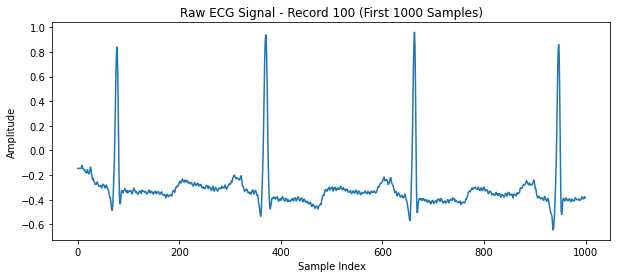

In [96]:
#Visualising raw signal with an example
example_record = "100"
raw_signal = database[example_record]["record"].p_signal[:, 0]

plt.figure(figsize=(10,4))
plt.plot(raw_signal[:1000])
plt.title(f"Raw ECG Signal - Record {example_record} (First 1000 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

In [97]:
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=360, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

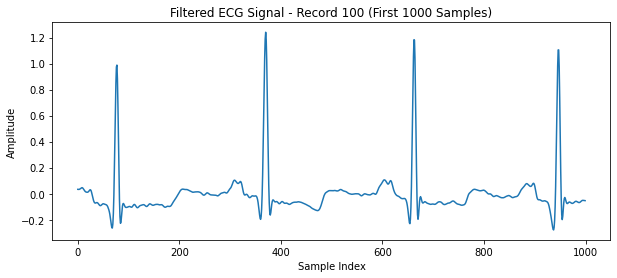

In [98]:
#Visualising a filtered signal with an example
example_record = "100"
raw_signal = database[example_record]["record"].p_signal[:, 0]

fs = database[example_record]["record"].fs
filtered_signal = bandpass_filter(raw_signal, fs=fs)

plt.figure(figsize=(10,4))
plt.plot(filtered_signal[:1000])
plt.title(f"Filtered ECG Signal - Record {example_record} (First 1000 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

In [99]:
def extract_beats(signal, r_peaks, beat_length=188, pre_peak=60):
    beats = []
    valid_indices = []
    for i, r in enumerate(r_peaks):
        start = r - pre_peak if r >= pre_peak else 0
        end = start + beat_length
        if end <= len(signal):
            beats.append(signal[start:end])
            valid_indices.append(i)
    return np.array(beats), valid_indices

In [100]:
def downsample_beats(beats, orig_fs=360, target_fs=125):
    num_samples = int(beats.shape[1] * (target_fs / orig_fs))
    downsampled = np.array([resample(beat, num_samples) for beat in beats])
    return downsampled

In [101]:
#Label mapping based on AAMI standards
label_mapping = {
    'N': 0,   # Normal beat
    'L': 0,   # Left bundle branch block beat (treated as Normal)
    'R': 0,   # Right bundle branch block beat (treated as Normal)
    'S': 1,   # Supraventricular ectopic beat
    'V': 2,   # Ventricular ectopic beat
    'F': 3,   # Fusion beat
    'Q': 4    # Unknown beat
}

In [102]:
extracted_beats = []
extracted_labels = []

In [103]:
for rec_id, data in database.items():
    try:
        raw_signal = data["record"].p_signal[:, 0]
        fs = data["record"].fs
        filtered_signal = bandpass_filter(raw_signal, fs=fs)
        r_peaks = data["annotations"].sample
        beats, valid_indices = extract_beats(filtered_signal, r_peaks, beat_length=188, pre_peak=60)
        beats_ds = downsample_beats(beats, orig_fs=fs, target_fs=125)
        annotations = data["annotations"]
        all_labels_for_record = [label_mapping.get(sym, None) for sym in annotations.symbol]
        
        for index, beat in zip(valid_indices, beats_ds):
            label = all_labels_for_record[index]
            if label is not None:
                extracted_beats.append(beat)
                extracted_labels.append(label)
                
        print(f"Extracted beats in record {rec_id}: {len(valid_indices)} ")
    except Exception as e:
        print(f"Error processing record {rec_id}: {e}")

Extracted beats in record 100: 2273 
Extracted beats in record 101: 1874 
Extracted beats in record 102: 2192 
Extracted beats in record 103: 2090 
Extracted beats in record 104: 2310 
Extracted beats in record 105: 2691 
Extracted beats in record 106: 2098 
Extracted beats in record 107: 2140 
Extracted beats in record 108: 1824 
Extracted beats in record 109: 2534 
Extracted beats in record 111: 2133 
Extracted beats in record 112: 2549 
Extracted beats in record 113: 1795 
Extracted beats in record 114: 1890 
Extracted beats in record 115: 1961 
Extracted beats in record 116: 2420 
Extracted beats in record 117: 1538 
Extracted beats in record 118: 2301 
Extracted beats in record 119: 2094 
Extracted beats in record 121: 1875 
Extracted beats in record 122: 2478 
Extracted beats in record 123: 1519 
Extracted beats in record 124: 1633 
Extracted beats in record 200: 2791 
Extracted beats in record 201: 2039 
Extracted beats in record 202: 2145 
Extracted beats in record 203: 3108 
E

In [104]:
print("Total beats extracted from all records:", len(extracted_beats))

unique, counts = np.unique(extracted_labels, return_counts=True)
print("Label distribution from all records:")
dist = dict(zip(unique.tolist(), counts.tolist()))
print(", ".join(f"{int(k)}:{int(v)}" for k, v in dist.items()))

Total beats extracted from all records: 98333
Label distribution from all records:
0:90365, 1:2, 2:7130, 3:803, 4:33


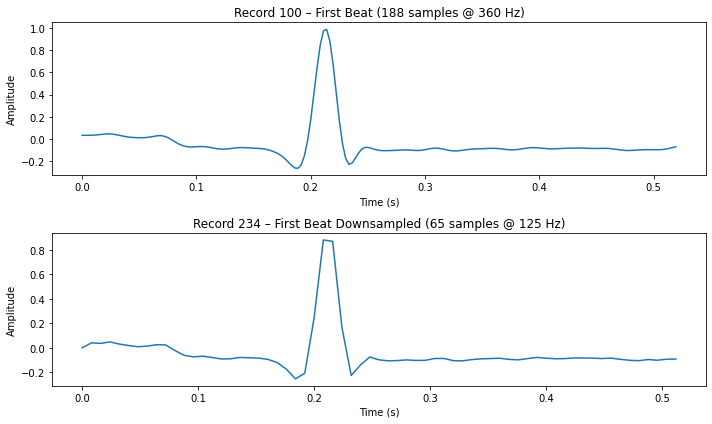

In [105]:
#Visualizing extracted and downsampled beats with an example
example_record = "100"
raw_signal = database[example_record]["record"].p_signal[:, 0]

fs = database[example_record]["record"].fs
filtered_signal = bandpass_filter(raw_signal, fs=fs)

r_peaks = database[example_record]["annotations"].sample
beats, valid_indices = extract_beats(filtered_signal, r_peaks, beat_length=188, pre_peak=60)
beats_ds = downsample_beats(beats, orig_fs=fs, target_fs=125)

extracted_beat = beats[0]
downsampled_beat = beats_ds[0]

time = np.arange(len(extracted_beat)) / fs
time_ds = np.arange(len(downsampled_beat)) / 125

fig, (fig1, fig2) = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

fig1.plot(time, extracted_beat)
fig1.set_title(f"Record {example_record} – First Beat ({len(extracted_beat)} samples @ {fs} Hz)")
fig1.set_ylabel("Amplitude")
fig1.set_xlabel("Time (s)")

fig2.plot(time_ds, downsampled_beat)
fig2.set_title(f"Record {rec_id} – First Beat Downsampled ({len(downsampled_beat)} samples @ 125 Hz)")
fig2.set_ylabel("Amplitude")
fig2.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

In [106]:
def normalize_beats(beats):
    normalized = []
    for beat in beats:
        mean_val = np.mean(beat)
        std_val = np.std(beat)
        if std_val != 0:
            normalized.append((beat - mean_val) / std_val)
        else:
            normalized.append(beat - mean_val)
    return np.array(normalized)

In [107]:
normalized_beats = normalize_beats(np.array(extracted_beats))
print("Normalized beats shape:", normalized_beats.shape)

Normalized beats shape: (98333, 65)


In [108]:
#Reshape to 3D shape, which is most deep learning layers expect for a single channel time series
x = normalized_beats.reshape(normalized_beats.shape[0], normalized_beats.shape[1], 1)
y = np.array(extracted_labels)
print("Final dataset shapes: x =", x.shape, ", y =", y.shape)

Final dataset shapes: x = (98333, 65, 1) , y = (98333,)


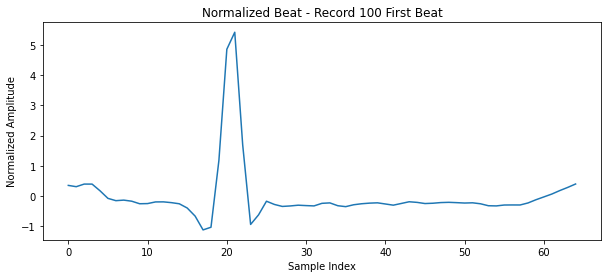

In [109]:
#Visualizing normalized beat
plt.figure(figsize=(10,4))
plt.plot(x[0].squeeze())
plt.title("Normalized Beat - Record 100 First Beat")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")
plt.show()

In [110]:
def build_resnet_model(input_shape, n_classes):
    #Residual block
    def residual_block(x, filters, kernel_size, stride=1):
        shortcut = x
        x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv1D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        if shortcut.shape[-1] != filters or stride != 1:
            shortcut = Conv1D(filters, 1, strides=stride, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        return x

    inputs = Input(shape=input_shape)
    
    #Downsampling block
    x = Conv1D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #3 residual blocks
    for _ in range(3):
        x = residual_block(x, filters=64, kernel_size=3, stride=1)
        x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

    #classification
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    
    outputs = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [111]:
def build_cnn_lstm_model(input_shape, n_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)   
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)  
    x = LSTM(64)(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(64, activation='relu')(x)

    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [112]:
cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [113]:
performance_metrics = {'ResNet': [], 'CNN_LSTM': [], 'KNN':[]}

In [114]:
flat_dataset = x.reshape(x.shape[0], -1)
scaler = StandardScaler().fit(flat_dataset)

In [115]:
warnings.filterwarnings("ignore", category=UserWarning)

for fold_index, (train_index, test_index) in enumerate(cross_validation.split(x, y), start=1):
    print("\n===========================================================================")
    print(f"\n**** FOLD - {fold_index} ****")
    
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #oversample the training set for balanced input
    n_samples, sequence_length, n_channels = x_train.shape
    x_train_flat = x_train.reshape(n_samples, -1)
    
    #select over sampler based on the use-case
    class_count = np.min(np.bincount(y_train))
    if class_count >= 5:
        oversampler = SMOTE(random_state=42)
    else:
        oversampler = RandomOverSampler(random_state=42)
        
    x_train_flat_balanced, y_train_balanced = oversampler.fit_resample(x_train_flat, y_train)
    x_train_balanced = x_train_flat_balanced.reshape(-1, sequence_length, n_channels)
    
    #one-hot encoding labels for keras model
    y_train_encoded = tf.keras.utils.to_categorical(y_train_balanced, 5)
    y_test_encoded = tf.keras.utils.to_categorical(y_test, 5)
    
    #train ResNet model - model 1
    m1 = build_resnet_model((sequence_length, n_channels), 5)
    m1.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    m1.fit(x_train_balanced, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    
    rn_predictions = np.argmax(m1.predict(x_test), axis=1)
    rn_accuracy = accuracy_score(y_test, rn_predictions)
    rn_precision = precision_score(y_test, rn_predictions, average='weighted', zero_division=0)
    rn_recall = recall_score(y_test, rn_predictions, average='weighted', zero_division=0)
    rn_f1 = f1_score(y_test, rn_predictions, average='weighted', zero_division=0)
    
    performance_metrics['ResNet'].append([rn_accuracy, rn_precision, rn_recall, rn_f1])
    print(f"ResNet — Accuracy: {rn_accuracy:.3f}, Precision: {rn_precision:.3f}, Recall: {rn_recall:.3f}, F1: {rn_f1:.3f}")
    
    #train CNN+LSTM model - model 2
    m2 = build_cnn_lstm_model((sequence_length, n_channels), 5)
    m2.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    m2.fit(x_train_balanced, y_train_encoded, epochs=20, batch_size=64, verbose=0)
    
    cnn_lstm_predictions = np.argmax(m2.predict(x_test), axis=1)
    cnn_lstm_accuracy = accuracy_score(y_test, cnn_lstm_predictions)
    cnn_lstm_precision = precision_score(y_test, cnn_lstm_predictions, average='weighted', zero_division=0)
    cnn_lstm_recall = recall_score(y_test, cnn_lstm_predictions, average='weighted', zero_division=0)
    cnn_lstm_f1 = f1_score(y_test, cnn_lstm_predictions, average='weighted', zero_division=0)
    
    performance_metrics['CNN_LSTM'].append([cnn_lstm_accuracy, cnn_lstm_precision, cnn_lstm_recall, cnn_lstm_f1])
    print(f"CNN+LSTM — Accuracy: {cnn_lstm_accuracy:.3f}, Precision: {cnn_lstm_precision:.3f}, Recall: {cnn_lstm_recall:.3f}, F1: {cnn_lstm_f1:.3f}")
    
    #train KNN model - model 3
    #flatten and scale train and validation data sets
    x_train_flat = flat_dataset[train_index]
    x_test_flat = flat_dataset[test_index]
    x_train_scaled = scaler.transform(x_train_flat)
    x_test_scaled = scaler.transform(x_test_flat)
    
    #oversample for KNN
    x_train_knn_balanced, y_train_knn_balanced = oversampler.fit_resample(x_train_scaled, y_train)
    m3 = KNeighborsClassifier(n_neighbors=5)
    m3.fit(x_train_knn_balanced, y_train_knn_balanced)
    
    knn_predictions = m3.predict(x_test_scaled)
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    knn_precision = precision_score(y_test, knn_predictions, average='weighted', zero_division=0)
    knn_recall = recall_score(y_test, knn_predictions, average='weighted', zero_division=0)
    knn_f1 = f1_score(y_test, knn_predictions, average='weighted', zero_division=0)
    
    performance_metrics['KNN'].append([knn_accuracy, knn_precision, knn_recall, knn_f1])
    print(f"KNN — Accuracy: {knn_accuracy:.3f}, Precision: {knn_precision:.3f}, Recall: {knn_recall:.3f}, F1: {knn_f1:.3f}")



**** FOLD - 1 ****
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ResNet — Accuracy: 0.994, Precision: 0.994, Recall: 0.994, F1: 0.994
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CNN+LSTM — Accuracy: 0.991, Precision: 0.993, Recall: 0.991, F1: 0.992
KNN — Accuracy: 0.993, Precision: 0.993, Recall: 0.993, F1: 0.993


**** FOLD - 2 ****
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
ResNet — Accuracy: 0.995, Precision: 0.995, Recall: 0.995, F1: 0.995
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CNN+LSTM — Accuracy: 0.990, Precision: 0.991, Recall: 0.990, F1: 0.990
KNN — Accuracy: 0.991, Precision: 0.991, Recall: 0.991, F1: 0.991


**** FOLD - 3 ****
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ResNet — Accuracy: 0.995, Precision: 0.995, Recall: 0.995, F1: 0.995
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CNN+LSTM — Accuracy: 0.994, Precision: 0.995, Recall: 0.994, F1: 0.994
KNN — Accuracy: 0.992, Precision: 0.993, Recall: 0.992, F1: 0.992


**** FOLD - 4 ****
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
ResNet — Ac

In [116]:
#Average performance metrics
print("\n+++++++++++++++++++++++AVERAGE PERFORMANCE+++++++++++++++++++++++")
for model, scores in performance_metrics.items():
    score_values = np.array(scores)
    mean_accuracy = score_values[:, 0].mean()
    mean_precision = score_values[:,1].mean()
    mean_recall  = score_values[:,2].mean()
    mean_f1   = score_values[:,3].mean()
   
    print(f"\n{model} — Accuracy: {mean_accuracy:.3f}, Precision: {mean_precision:.3f}, Recall: {mean_recall:.3f}, F1: {mean_f1:.3f}")


+++++++++++++++++++++++AVERAGE PERFORMANCE+++++++++++++++++++++++

ResNet — Accuracy: 0.994, Precision: 0.994, Recall: 0.994, F1: 0.994

CNN_LSTM — Accuracy: 0.993, Precision: 0.993, Recall: 0.993, F1: 0.993

KNN — Accuracy: 0.992, Precision: 0.992, Recall: 0.992, F1: 0.992


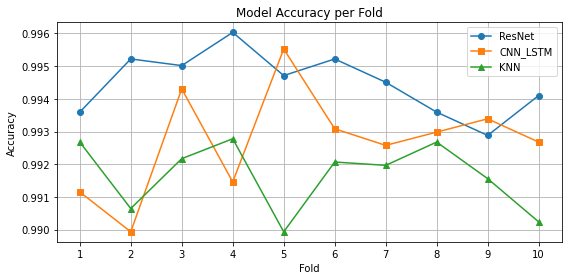

In [117]:
#Visualize model performance
folds = np.arange(1, 11)
rn_accuracy = np.array(performance_metrics['ResNet'])[:, 0]
cnn_lstm_accuracy = np.array(performance_metrics['CNN_LSTM'])[:, 0]
knn_accuracy = np.array(performance_metrics['KNN'])[:, 0]

plt.figure(figsize=(8,4))
plt.plot(folds, rn_accuracy, marker='o', label='ResNet')
plt.plot(folds, cnn_lstm_accuracy, marker='s', label='CNN_LSTM')
plt.plot(folds, knn_accuracy, marker='^', label='KNN')
plt.xticks(folds)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Fold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

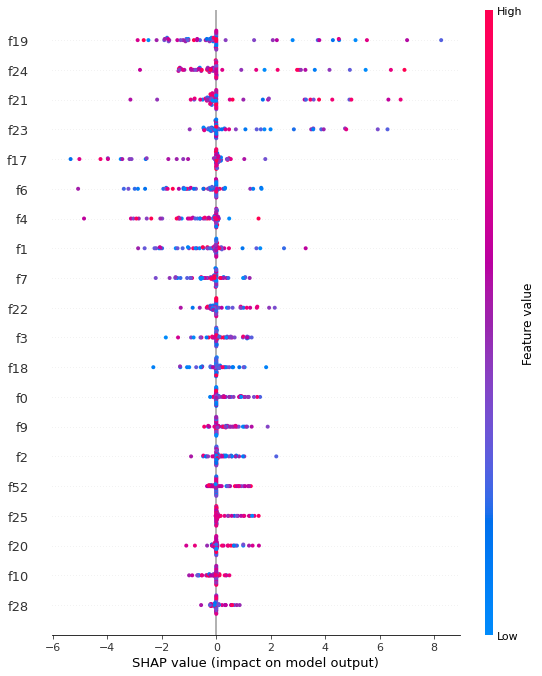

In [119]:
#Interpretability using SHAP - Applying on the best performing model ResNet
if x_train_balanced.shape[0] > 250:
    shap_background_index = np.random.choice(x_train_balanced.shape[0], 250, replace=False)
else:
    shap_background_index = np.arange(x_train_balanced.shape[0])

background = x_train_balanced[shap_background_index]
test_samples = x_test[:64]

logits_layer = m1.layers[-1].input
logit_model = Model(inputs=m1.input, outputs=logits_layer)

explainer = shap.DeepExplainer(logit_model, background)
shap_values = explainer.shap_values(test_samples, check_additivity=False)

shap_values_transform = np.transpose(shap_values[0], (2, 0, 1)) 
shap_values_transform = shap_values_transform.squeeze(axis=2) 

test_samples_transform = test_samples.squeeze(axis=2)

shap.summary_plot(shap_values_transform, 
                  test_samples_transform, 
                  feature_names=[f"f{i}" for i in range(test_samples_transform.shape[1])]
)

In [120]:
#Example for shap values of a sample
shap_val_0 = shap_values[0]

if hasattr(shap_val_0, "numpy"):
    shap_val_0 = shap_val_0.numpy()

#Print shap values of sample 10
values = shap_val_0[:, 0, 10]

print("SHAP values for sample 10:")
print(values)

SHAP values for sample 10:
[ 0.01334562 -0.23039812 -0.02725792  0.11336807  0.06248583  0.01024787
 -0.21931537 -0.20498893  0.01428277  0.04437632 -0.04020668 -0.02949637
 -0.05104071  0.00758712  0.01182867 -0.0210426  -0.0588735   0.17267636
  0.05615729 -0.69943222 -0.04484416 -0.32878478 -0.12880101 -0.29679255
 -0.27527072  0.00945215  0.01615907 -0.03638362 -0.04348705  0.00120754
 -0.02600161 -0.05151399 -0.03640538 -0.0088038  -0.03325367  0.01924564
  0.00290272 -0.00159638 -0.01981456 -0.02616213 -0.01476373 -0.02810391
 -0.02434471 -0.01525277 -0.02166544  0.00437475  0.03197329 -0.07034768
 -0.04857841 -0.02422914 -0.02316288 -0.01251167 -0.02031964 -0.01471607
 -0.01526209  0.00076921 -0.01880173 -0.01666222  0.0065067  -0.00901817
 -0.00915458 -0.02525634 -0.01063959 -0.0570674  -0.07464501]
